In [24]:
from lammps_file_writer import support as sp

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

In [6]:
seeds_file = "./seeds/seeds" 
seeds      = sp.read_seeds(seeds_file)

frequencies_file = "./frequencies/frequencies"
frequencies      = sp.read_seeds(frequencies_file)

# colloids trajecotries

In [22]:
def parse_frame(frame):
    return pd.DataFrame(frame[:,1:], columns = ["type","x","y"], 
                 index = pd.Index(frame[:,0], name = "id"))

def trajectories(freq, seed, dir_path, particle_ids=None, time_range=None):
    """Read LAMMPS dump and return trajectory data with type 2 particles only at initial frame"""
    # Read the trajectory file
    trj = sp.read_timesteps(os.path.join(dir_path, f"mag_ratchet_{freq}Hz_{seed}.lammpstrj"))
    
    # Combine all frames into a single DataFrame
    trj_df = pd.concat([parse_frame(trj[k]) for k in trj.keys()],
                      keys=trj.keys(), names=["frame"])
    
    # Reset index to make frame and particle IDs accessible as columns
    trj_df = trj_df.reset_index().reset_index(drop=True)
    
    # Filter by time range if specified
    if time_range is not None:
        start_frame, end_frame = time_range
        trj_df = trj_df[(trj_df['frame'] >= start_frame) & (trj_df['frame'] <= end_frame)]
    
    # Separate type 1 and type 2 particles
    type1_df = trj_df[trj_df['type'] == 1].copy()
    type2_df = trj_df[trj_df['type'] == 2].copy()
    
    # For type 2 particles, keep only the initial frame (minimum frame number)
    if not type2_df.empty:
        initial_frame = type2_df['frame'].min()
        type2_df = type2_df[type2_df['frame'] == initial_frame]
    
    # Combine back together
    result_df = pd.concat([type1_df, type2_df], ignore_index=True)

    print("Columns in the DataFrame:", trj_df.columns.tolist())
    
    return result_df

def unwrap_coordinates(df, box_size_x, box_size_y):
    """Unwrap with known box dimensions"""
    df = df.sort_values(['id', 'frame'])
    
    groups = df.groupby('id')
    unwrapped_data = []
    
    for particle_id, group in groups:
        group = group.sort_values('frame')
        
        x_uw = [group['x'].iloc[0]]
        y_uw = [group['y'].iloc[0]]
        
        for i in range(1, len(group)):
            dx = group['x'].iloc[i] - group['x'].iloc[i-1]
            dy = group['y'].iloc[i] - group['y'].iloc[i-1]

            
            # Adjust for PBC jumps
            if abs(dx) > box_size_x/2:
                dx -= np.sign(dx) * box_size_x
            if abs(dy) > box_size_y/2:
                dy -= np.sign(dy) * box_size_y
                
            x_uw.append(x_uw[-1] + dx)
            y_uw.append(y_uw[-1] + dy)
        
        group = group.copy()
        group['x_unwrapped'] = x_uw
        group['y_unwrapped'] = y_uw
        unwrapped_data.append(group)
    
    return pd.concat(unwrapped_data, ignore_index=True)

In [25]:
data = trajectories(7, 123456, './results/files_50M', 1, (0, 500000))
traj_data_unwrapped = unwrap_coordinates(data, 54, 54)

Columns in the DataFrame: ['frame', 'id', 'type', 'x', 'y']


In [30]:
type1_data = traj_data_unwrapped[traj_data_unwrapped['type'] == 1]
type2_data = traj_data_unwrapped[traj_data_unwrapped['type'] == 2]

initial_frame = type2_data['frame'].min()
type2_initial = type2_data[type2_data['frame'] == initial_frame]

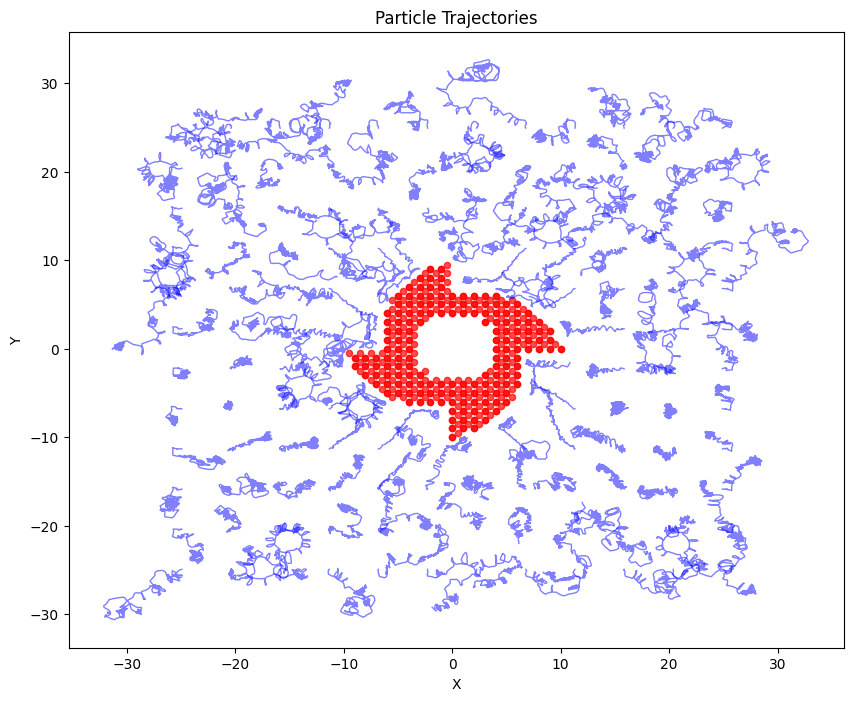

In [31]:
plt.figure(figsize=(10, 8))
for particle_id in type1_data['id'].unique():
    particle_data = type1_data[type1_data['id'] == particle_id]
    plt.plot(particle_data['x_unwrapped'], particle_data['y_unwrapped'], 
             'b-', alpha=0.5, linewidth=1)

plt.scatter(type2_initial['x_unwrapped'], type2_initial['y_unwrapped'], 
           color='red', s=20, alpha=0.7, label='Type 2 (initial)')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Particle Trajectories')
plt.show()